Yelnur Shauketbek: Autoencoders

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [2]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [3]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

Files already downloaded and verified
Files already downloaded and verified


In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [5]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [7]:
# Set niose factor for later
noise_factor = 0.1

In [7]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

In [42]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

In [9]:
ENCODING_DIM = 100 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

In [10]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [11]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00440
Test mse: 0.00443


In [9]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

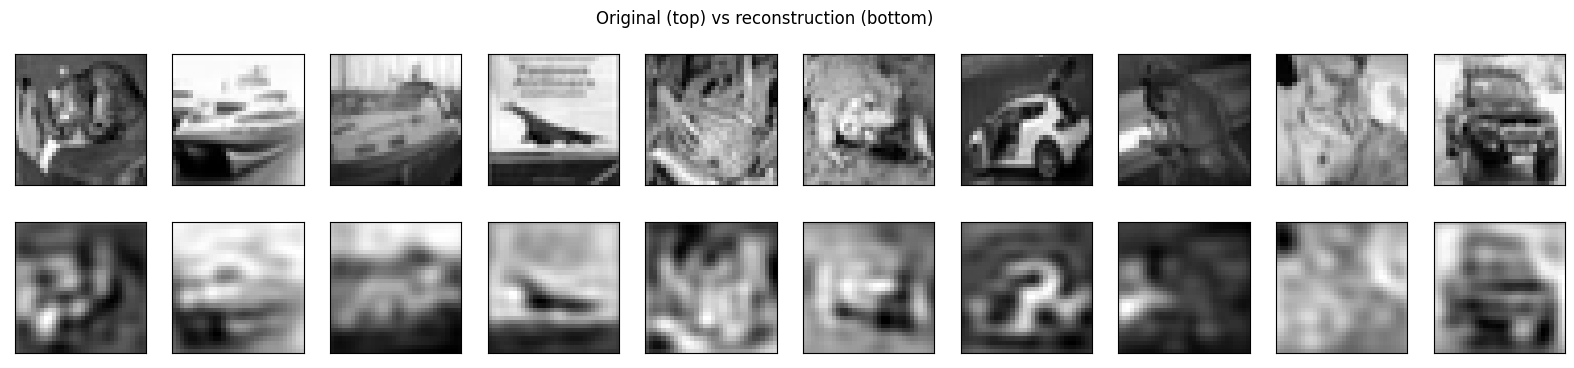

In [13]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.3 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

In [11]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

In [30]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 38 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [12]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [33]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.85010910 ---------------- Val_Acc: Val_Loss: 0.24068208
epoch: 2 -> Loss: 0.18383846 ---------------- Val_Acc: Val_Loss: 0.14269215
epoch: 3 -> Loss: 0.11765829 ---------------- Val_Acc: Val_Loss: 0.09884410
epoch: 4 -> Loss: 0.08425282 ---------------- Val_Acc: Val_Loss: 0.07403180
epoch: 5 -> Loss: 0.06635200 ---------------- Val_Acc: Val_Loss: 0.05863603
epoch: 6 -> Loss: 0.05099823 ---------------- Val_Acc: Val_Loss: 0.04742841
epoch: 7 -> Loss: 0.04210960 ---------------- Val_Acc: Val_Loss: 0.03908632
epoch: 8 -> Loss: 0.03590675 ---------------- Val_Acc: Val_Loss: 0.03492729
epoch: 9 -> Loss: 0.03025312 ---------------- Val_Acc: Val_Loss: 0.02888943
epoch: 10 -> Loss: 0.02638387 ---------------- Val_Acc: Val_Loss: 0.02508054
epoch: 11 -> Loss: 0.02338497 ---------------- Val_Acc: Val_Loss: 0.02261647
epoch: 12 -> Loss: 0.02059970 ---------------- Val_Acc: Val_Loss: 0.01984152
epoch: 13 -> Loss: 0.01871672 ---------------- Val_Acc: Val_Loss: 0.01808420
epoch: 1

In [13]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

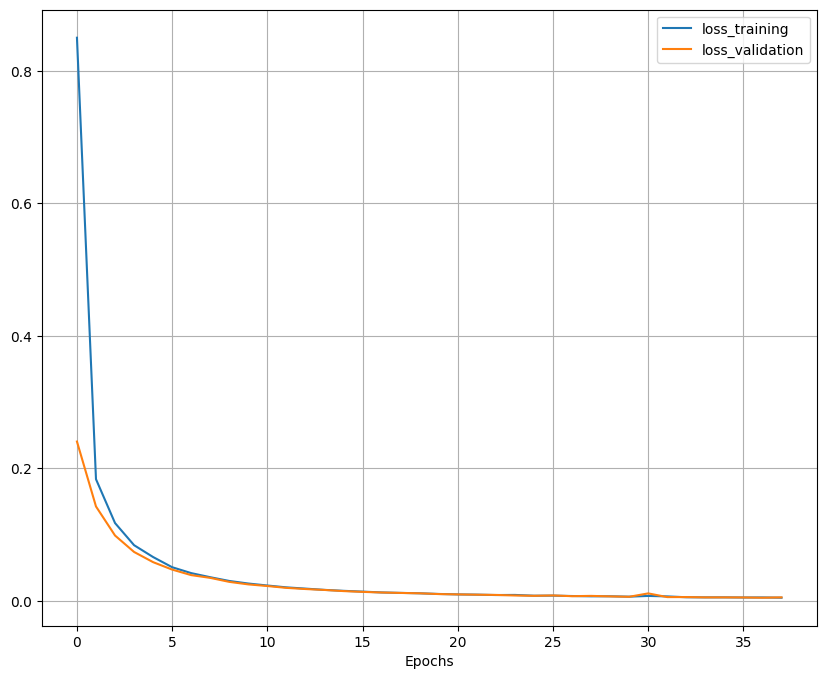

In [35]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [14]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [37]:
test(Shallow_AE)

Test Loss: 0.00551069


In [15]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [39]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

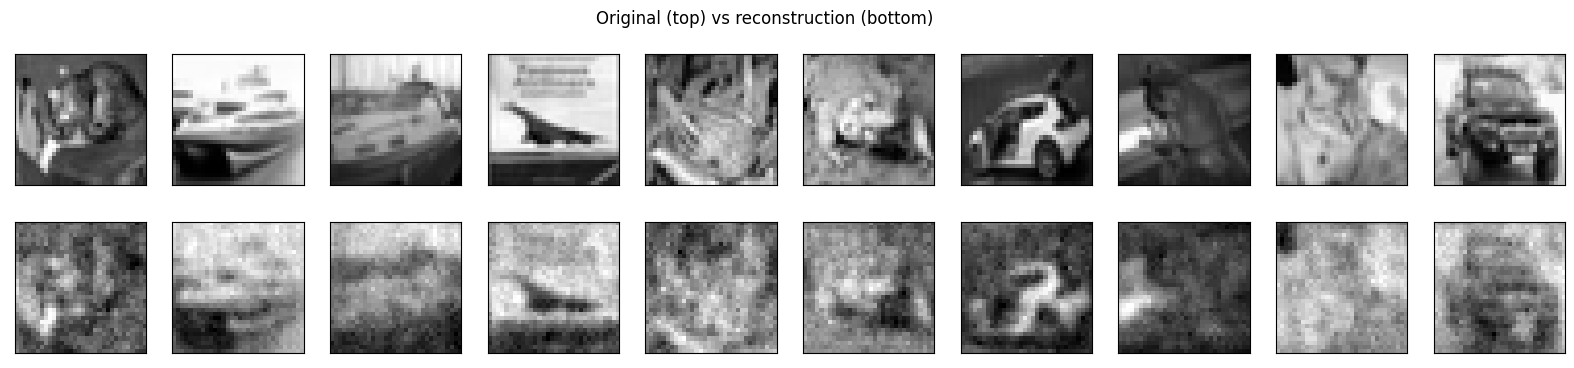

In [40]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

In [57]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'leaky_relu' # 'sigmoid', 'relu', 'tanh', 'leaky_relu'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# [TO COMPLETE]
# define model and training hyperparameters
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [58]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [59]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04552467 ---------------- Val_Acc: Val_Loss: 0.03421010
epoch: 2 -> Loss: 0.02712657 ---------------- Val_Acc: Val_Loss: 0.02836337
epoch: 3 -> Loss: 0.02329420 ---------------- Val_Acc: Val_Loss: 0.02154340
epoch: 4 -> Loss: 0.01950356 ---------------- Val_Acc: Val_Loss: 0.01854056
epoch: 5 -> Loss: 0.01820296 ---------------- Val_Acc: Val_Loss: 0.01858432
epoch: 6 -> Loss: 0.01710063 ---------------- Val_Acc: Val_Loss: 0.01668724
epoch: 7 -> Loss: 0.01668727 ---------------- Val_Acc: Val_Loss: 0.01598483
epoch: 8 -> Loss: 0.01574564 ---------------- Val_Acc: Val_Loss: 0.01566333
epoch: 9 -> Loss: 0.01549785 ---------------- Val_Acc: Val_Loss: 0.01507167
epoch: 10 -> Loss: 0.01504203 ---------------- Val_Acc: Val_Loss: 0.01479128
epoch: 11 -> Loss: 0.01457972 ---------------- Val_Acc: Val_Loss: 0.01440662
epoch: 12 -> Loss: 0.01418331 ---------------- Val_Acc: Val_Loss: 0.01405584
epoch: 13 -> Loss: 0.01393170 ---------------- Val_Acc: Val_Loss: 0.01365143
epoch: 1

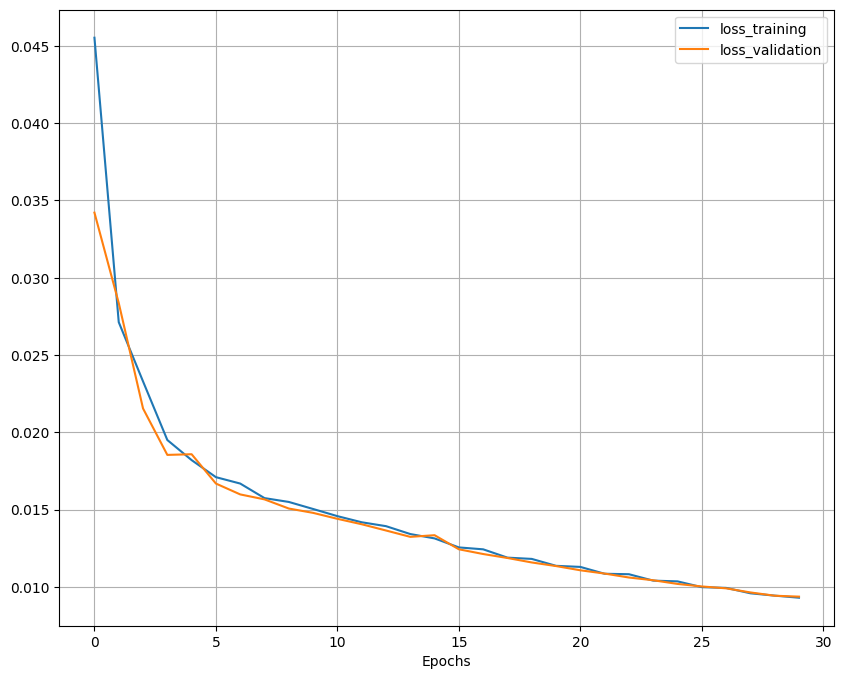

In [60]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [61]:
test(Shallow_non_AE)

Test Loss: 0.00936273


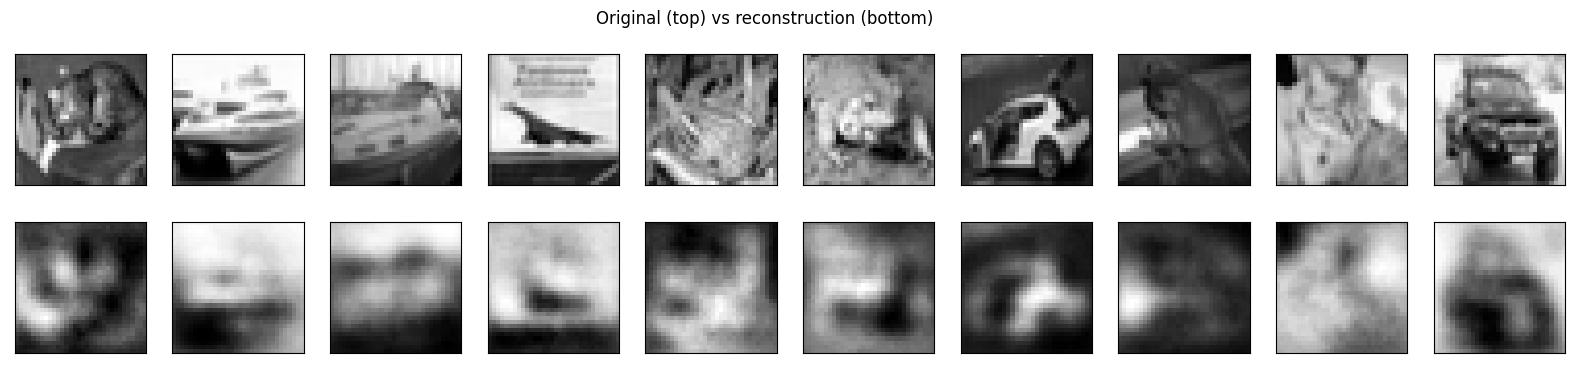

In [62]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

In [71]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024,512,256] 
DEC_LAYERS = [512,1024] 
ACT_FUN = 'sigmoid'
lr = 0.0005
epochs = 100 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# [TO COMPLETE]
# define model and training hyperparameters
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 512]                131,584
│    └─Linear: 2-5                       [512, 1024]               525,312
│    └─Linear: 2-6                       [512, 1024]               1,049,600
Total params: 3,412,224
Trainable params: 3,412,224
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 2.10
Forward/backward pass size (MB): 17.83
Params size (MB): 13.65
Estimated Total Size (MB): 33.57

In [72]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [73]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.05804672 ---------------- Val_Acc: Val_Loss: 0.04049860
epoch: 2 -> Loss: 0.03322415 ---------------- Val_Acc: Val_Loss: 0.02961442
epoch: 3 -> Loss: 0.02785201 ---------------- Val_Acc: Val_Loss: 0.02688120
epoch: 4 -> Loss: 0.02482579 ---------------- Val_Acc: Val_Loss: 0.02326835
epoch: 5 -> Loss: 0.02188459 ---------------- Val_Acc: Val_Loss: 0.02114121
epoch: 6 -> Loss: 0.02049481 ---------------- Val_Acc: Val_Loss: 0.01990755
epoch: 7 -> Loss: 0.01939308 ---------------- Val_Acc: Val_Loss: 0.01905715
epoch: 8 -> Loss: 0.01844519 ---------------- Val_Acc: Val_Loss: 0.01811438
epoch: 9 -> Loss: 0.01771039 ---------------- Val_Acc: Val_Loss: 0.01742605
epoch: 10 -> Loss: 0.01699924 ---------------- Val_Acc: Val_Loss: 0.01670766
epoch: 11 -> Loss: 0.01627538 ---------------- Val_Acc: Val_Loss: 0.01605827
epoch: 12 -> Loss: 0.01570658 ---------------- Val_Acc: Val_Loss: 0.01559466
epoch: 13 -> Loss: 0.01528747 ---------------- Val_Acc: Val_Loss: 0.01520608
epoch: 1

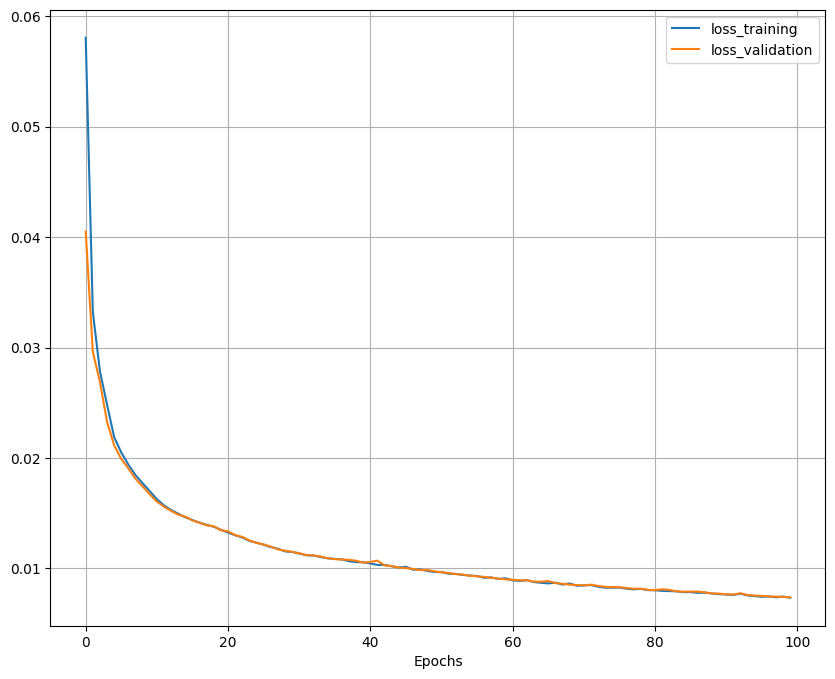

In [74]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [75]:
test(DEEP_non_AE)

Test Loss: 0.00734881


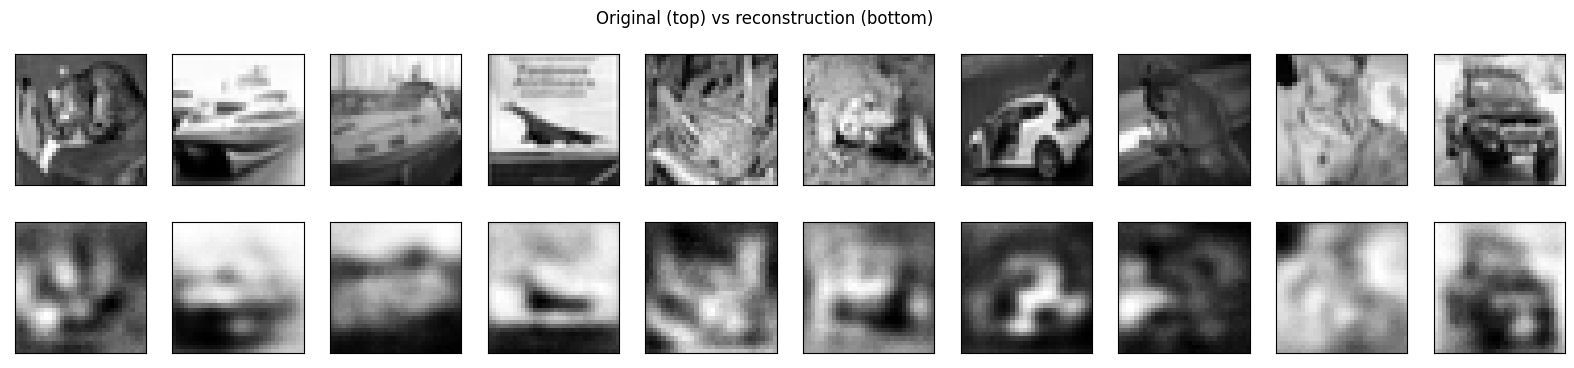

In [76]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

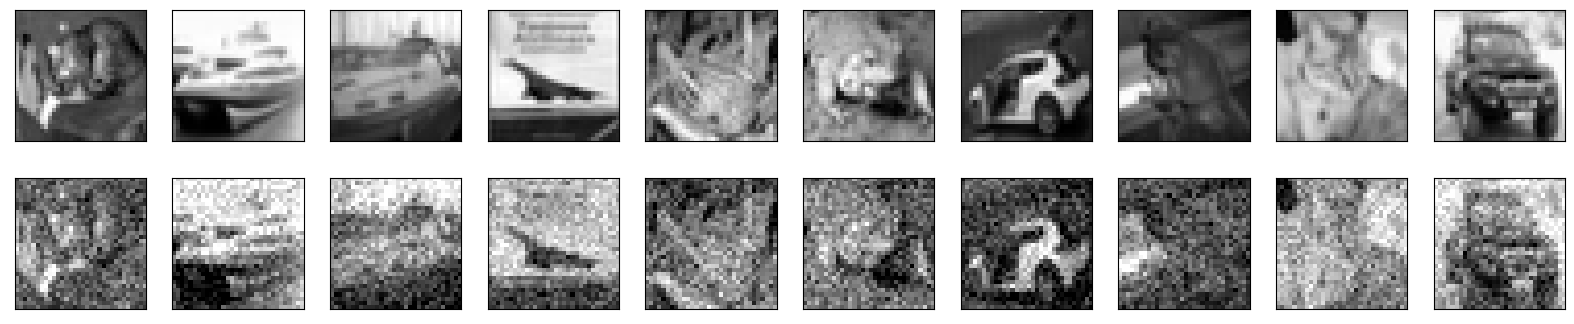

In [34]:
plot_img(10, [x_test, x_test_noisy])

In [35]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [37]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [38]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 1.79945028 ---------------- Val_Acc: Val_Loss: 0.77855861
epoch: 2 -> Loss: 0.49465495 ---------------- Val_Acc: Val_Loss: 0.29953349
epoch: 3 -> Loss: 0.20866638 ---------------- Val_Acc: Val_Loss: 0.14228301
epoch: 4 -> Loss: 0.10683824 ---------------- Val_Acc: Val_Loss: 0.08106421
epoch: 5 -> Loss: 0.06750976 ---------------- Val_Acc: Val_Loss: 0.05207393
epoch: 6 -> Loss: 0.04322659 ---------------- Val_Acc: Val_Loss: 0.03688442
epoch: 7 -> Loss: 0.03224861 ---------------- Val_Acc: Val_Loss: 0.02873106
epoch: 8 -> Loss: 0.02594176 ---------------- Val_Acc: Val_Loss: 0.02383229
epoch: 9 -> Loss: 0.02245230 ---------------- Val_Acc: Val_Loss: 0.02112721
epoch: 10 -> Loss: 0.01989650 ---------------- Val_Acc: Val_Loss: 0.01884908
epoch: 11 -> Loss: 0.01810037 ---------------- Val_Acc: Val_Loss: 0.01788359
epoch: 12 -> Loss: 0.01685211 ---------------- Val_Acc: Val_Loss: 0.01619502
epoch: 13 -> Loss: 0.01572479 ---------------- Val_Acc: Val_Loss: 0.01594496
epoch: 1

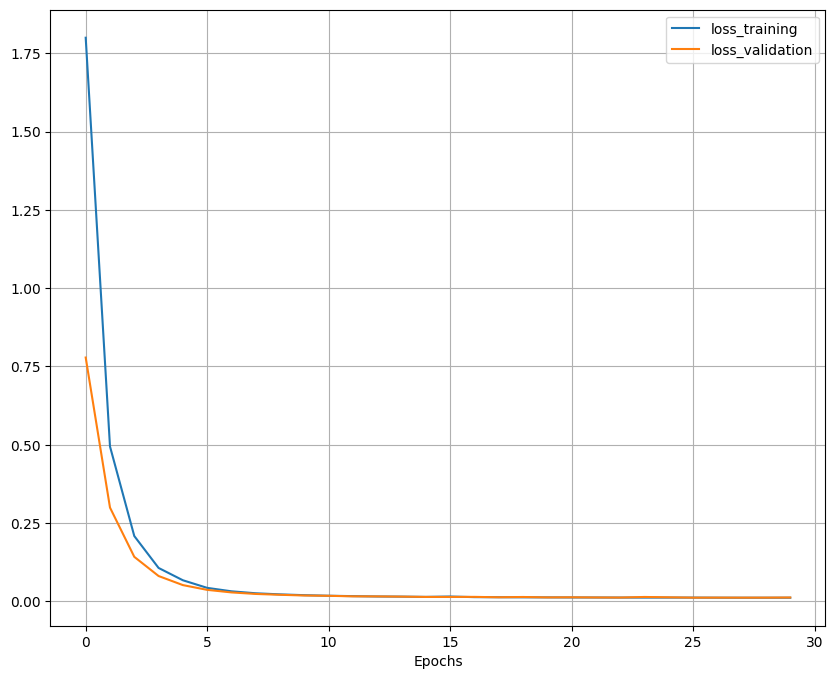

In [39]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [40]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.01033893


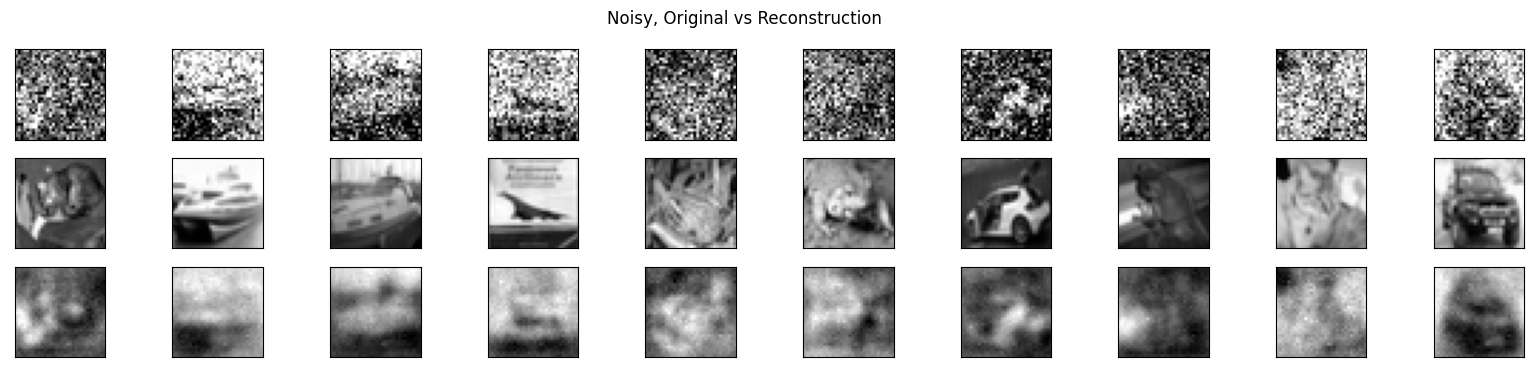

In [45]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")